In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
n_samples = 101

101

In [5]:
phase_x = zeros(Float32, 1, n_samples)

1×101 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
phase_y = range(start = -1.0, stop = 1.0, length = n_samples) |> collect;
phase_y = reshape(phase_y, 1, n_samples);

In [7]:
phase_z = bind(phase_x, phase_y)

1×101 Matrix{Float64}:
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  -1.0

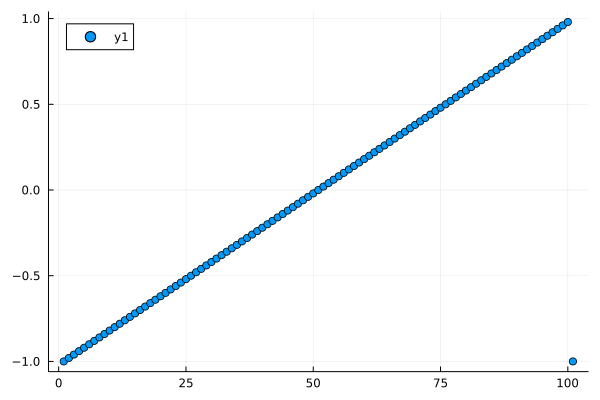

In [8]:
scatter(phase_z |> vec)

In [9]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [75]:
st_x = phase_to_train(phase_x, spk_args, repeats = 10)
st_y = phase_to_train(phase_y, spk_args, repeats = 10)

Spike Train: (1, 101) with 1010 spikes.

In [76]:
tspan = (0.0, 10.0)

(0.0, 10.0)

In [77]:
function neuron_constant(spk_args::SpikingArgs)
    angular_frequency = period_to_angfreq(spk_args.t_period)
    k = (spk_args.leakage + 1im * angular_frequency)
    return k
end

function period_to_angfreq(t_period::Real)
    angular_frequency = 2 * pi / t_period
    return angular_frequency
end

period_to_angfreq (generic function with 1 method)

In [78]:
using OrdinaryDiffEq

In [221]:
neuron_constant(sa)

-0.2 + 6.283185307179586im

In [222]:
real(neuron_constant(sa))

-0.2

In [223]:
imag(neuron_constant(sa))

6.283185307179586

In [359]:
function bind(x::SpikeTrain, y::SpikeTrain, tspan::Tuple{<:Real, <:Real}, spk_args::SpikingArgs; return_solution::Bool = false)
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)
    k1 = real(k) + 1im * imag(k)
    k2 = real(k) + -1im * imag(k)
    #get the number of batches & output neurons
    output_shape = x.shape

    #integrate current through the first compartment that will flow through into the second
    #set up the first compartment
    u0 = zeros(ComplexF32, output_shape)
    dzdt_x(u, p, t) = k1 .* u + spike_current(x, t, spk_args)
    #solve the ODE for the first compartment over the given time span
    prob_x = ODEProblem(dzdt_x, u0, tspan)
    sol_x = solve(prob_x, Heun(), adaptive=false, dt=spk_args.dt)

    #set up the second compartment
    #current will flow into the second compartment enabled by the second input and flow backards in time
    dzdt_y(u, p, t) = k2 .* u .+ sol_x(t) .* spike_current(y, t, spk_args)
    #dzdt_y(u, p, t) =  spike_current(y, t, spk_args)
    #solve the second compartment
    prob_y = ODEProblem(dzdt_y, u0, tspan)
    sol_y = solve(prob_y, Heun(), adaptive=false, dt=spk_args.dt)

    if return_solution
        return sol_x, sol_y
    end
    indices, times = find_spikes_rf(sol_y, spk_args)
    #construct the spike train and call for the next layer
    train = SpikeTrain(indices, times, output_shape, x.offset + spk_args.t_period / 4.0)
    next_call = SpikingCall(train, spk_args, tspan)
    return next_call

end

bind (generic function with 6 methods)

In [360]:
sa = SpikingArgs(threshold = 1e-4)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.0001 (V)


In [361]:
solx, soly = bind(st_x, st_y, tspan, sa, return_solution=true)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt_x#139"{SpikeTrain, SpikingArgs, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Heun{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt_x#139"{SpikeTrain, SpikingArgs, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [362]:
ux = Array(solx)
uy = Array(soly);

In [363]:
function plot_neuron(u, idx)
    plot(real.(u[1, idx, :]))
    plot!(imag.(u[1, idx, :]))
end

plot_neuron (generic function with 1 method)

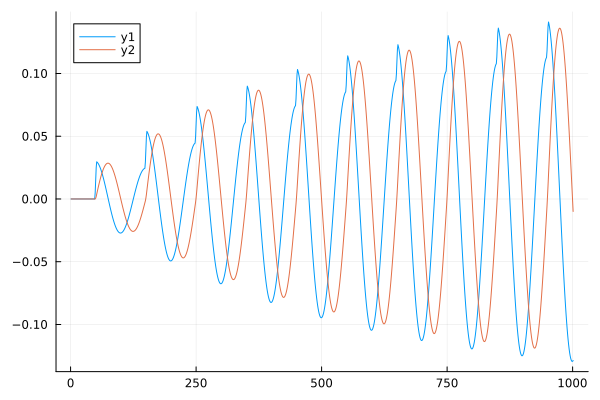

In [364]:
plot_neuron(ux, 50)

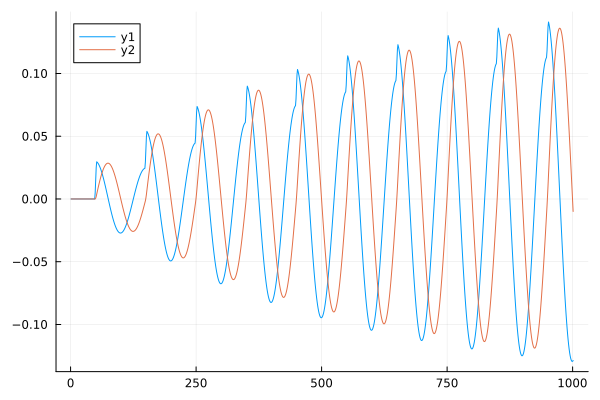

In [365]:
plot_neuron(ux, 25)

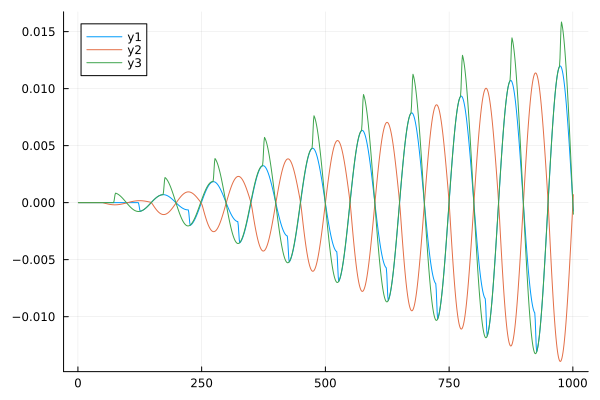

In [366]:
plot(imag.(uy[1,25,:]))
plot!(imag.(uy[1,50,:]))
plot!(imag.(uy[1,75,:]))

In [367]:
st_z = bind(st_x, st_y, tspan, sa)

SpikingCall(Spike Train: (1, 101) with 0 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.0001 (V)
, (0.0, 10.0))

In [368]:
ph = train_to_phase(st_z);

In [369]:
plot(ph[end,1,:])

MethodError: MethodError: no method matching axes(::Missing, ::Int64)
Closest candidates are:
  axes(!Matched::OffsetArrays.OffsetArray, ::Any) at ~/.julia/packages/OffsetArrays/TcCEq/src/OffsetArrays.jl:296
  axes(!Matched::ArrayLayouts.Mul, ::Int64) at ~/.julia/packages/ArrayLayouts/kR7AR/src/mul.jl:18
  axes(!Matched::RecipesPipeline.Volume, ::Any...) at ~/.julia/packages/RecipesPipeline/BGM3l/src/utils.jl:114
  ...

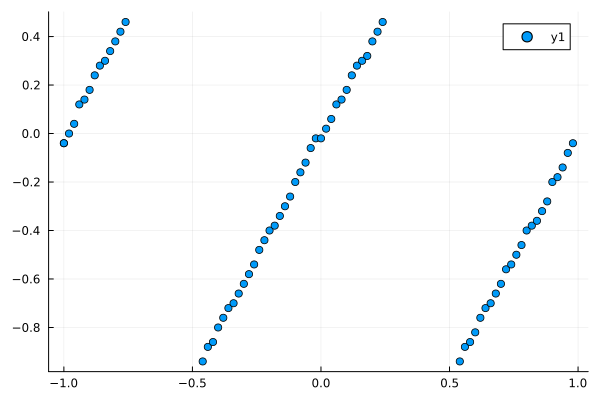

In [356]:
scatter(phase_z |> vec, ph[end,1,:])

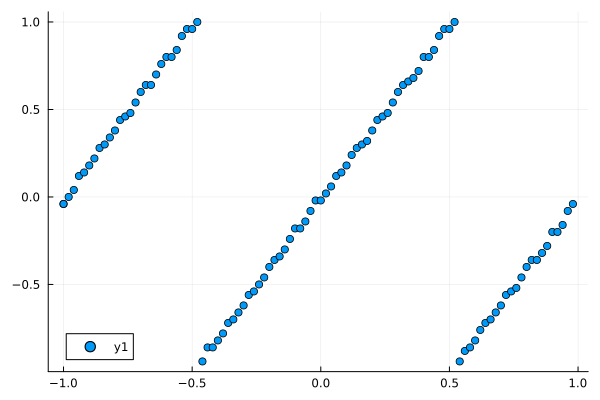

In [357]:
scatter(phase_z |> vec, ph[8,1,:])

In [21]:
u = dropdims(Array(st_z), dims=1)

101×1001 Matrix{ComplexF32}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …          0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …          0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
    ⋮                                        ⋱             ⋮
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im      -0.0022957+0.00455428im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -0.00283735+0.00421349im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -0.00333001+0.00380907im
 0.0+0.0im  0.0+0.0im  0.0+0.0i

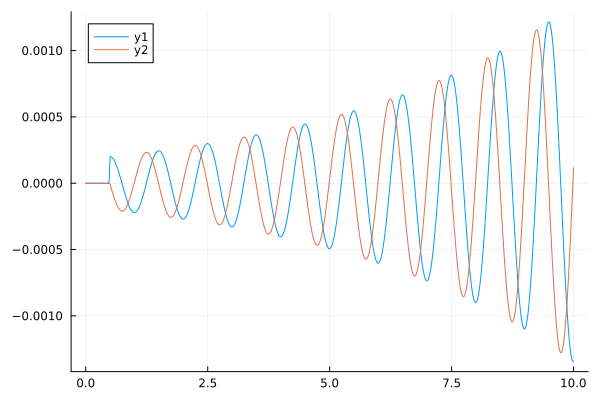

In [22]:
plot(st_z.t, real.(u[50, :]) )
plot!(st_z.t, imag.(u[50, :]))

In [23]:
u |> size

(101, 1001)

In [24]:
find_spikes_rf(st_z, sa)

(CartesianIndex{2}[CartesianIndex(1, 50), CartesianIndex(1, 51), CartesianIndex(1, 52), CartesianIndex(1, 53), CartesianIndex(1, 54), CartesianIndex(1, 55), CartesianIndex(1, 56), CartesianIndex(1, 57), CartesianIndex(1, 58), CartesianIndex(1, 59)  …  CartesianIndex(1, 55), CartesianIndex(1, 56), CartesianIndex(1, 57), CartesianIndex(1, 58), CartesianIndex(1, 59), CartesianIndex(1, 60), CartesianIndex(1, 61), CartesianIndex(1, 62), CartesianIndex(1, 63), CartesianIndex(1, 64)], [0.7400000000000004, 0.7500000000000004, 0.7600000000000005, 0.7900000000000005, 0.8100000000000005, 0.8300000000000005, 0.8500000000000005, 0.8700000000000006, 0.8900000000000006, 0.8900000000000006  …  9.829999999999835, 9.849999999999834, 9.869999999999834, 9.889999999999834, 9.889999999999834, 9.909999999999833, 9.929999999999833, 9.949999999999832, 9.969999999999832, 9.989999999999831])

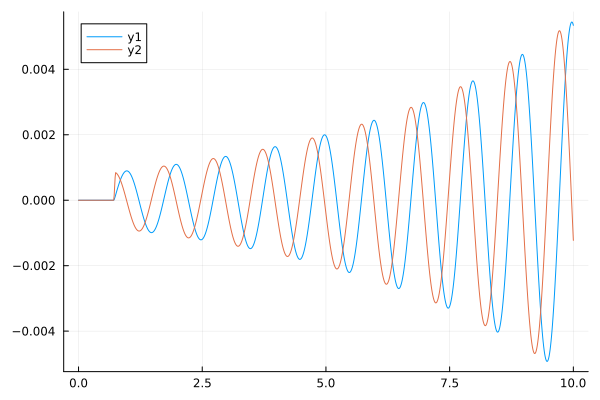

In [57]:
plot(st_z.t, real.(u[75, :]) )
plot!(st_z.t, imag.(u[75, :]))

In [40]:
find_spikes_rf(st_z, sa)

(CartesianIndex{2}[], Float64[])